Train Part

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [8]:
class ObjectDetector(nn.Module):
    def __init__(self):
        super(ObjectDetector, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 4)  # Output: (x, y, width, height)
        )

    def forward(self, img):
        features = self.conv(img)
        features = features.view(features.size(0), -1)  # Flatten
        bbox = self.fc(features)  # Predict bounding box
        return bbox

In [9]:
class CNNPositionPredictor(nn.Module):
    def __init__(self):
        super(CNNPositionPredictor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Fully Connected Layer: Predict (x, y)
        self.fc = nn.Sequential(
            nn.Linear(128 * 16 * 16 + 4, 128),  # 4 = one-hot action
            nn.ReLU(),
            nn.Linear(128, 2)  # Output: (x, y)
        )

    def forward(self, img, action):
        features = self.conv(img)
        features = features.view(features.size(0), -1)  # Flatten
        combined = torch.cat((features, action), dim=1)  # Merge with action
        pos = self.fc(combined)  # Predict final (x, y)
        return pos

In [10]:
class PositionDataset(Dataset):
    def __init__(self):
        self.actions = torch.cat([torch.load(f"actions_{i}.pt") for i in range(4)])
        self.imgs = torch.cat([torch.load(f"imgs_{i}.pt") for i in range(4)]).float() / 255.0
        self.positions = torch.cat([torch.load(f"positions_{i}.pt") for i in range(4)])

    def __len__(self):
        return len(self.positions)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        action = F.one_hot(self.actions[idx].long(), num_classes=4).float()
        pos = self.positions[idx]

        return img, action, pos


# Load dataset
dataset = PositionDataset()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
cnn_position_predictor = CNNPositionPredictor()
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_position_predictor.parameters(), lr=0.001)

for epoch in range(10):
    for img_before, action, pos in dataloader:
        optimizer.zero_grad()
        predictions = cnn_position_predictor(img_before, action)
        loss = criterion(predictions, pos)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Save trained model
torch.save(cnn_position_predictor.state_dict(), "hw1_3.pt")
print("CNN Position Predictor Saved!")

Epoch 1, Loss: 0.0716
Epoch 2, Loss: 0.0283
Epoch 3, Loss: 0.0034
Epoch 4, Loss: 0.0006
Epoch 5, Loss: 0.0002
Epoch 6, Loss: 0.0001
Epoch 7, Loss: 0.0001
Epoch 8, Loss: 0.0001
Epoch 9, Loss: 0.0001
Epoch 10, Loss: 0.0000
CNN Position Predictor Saved!


In [12]:
def extract_object(img_tensor):
    """
    Extracts the red object from `img_before` using predefined boundaries.
    """
    _, height, width = img_tensor.shape
    object_size = 20  # Fixed object size (adjust if needed)

    # Crop the center region where the object is expected
    x_start = width // 2 - object_size // 2
    y_start = height // 2 - object_size // 2
    x_end = x_start + object_size
    y_end = y_start + object_size

    return img_tensor[:, y_start:y_end, x_start:x_end]  # Extracted object

In [13]:
def overlay_object(img_before, img_after, final_pos):
    """
    Extracts the object from `img_before` and places it at `final_pos` on `img_after`.
    """
    obj_crop = extract_object(img_before)  # Extract object using fixed boundaries

    fx, fy = map(int, final_pos)  # Final position
    obj_size = obj_crop.shape[1]  # Fixed object size

    # Place object at final position
    img_after[:, fy:fy + obj_size, fx:fx + obj_size] = obj_crop

    return img_after

Test Part

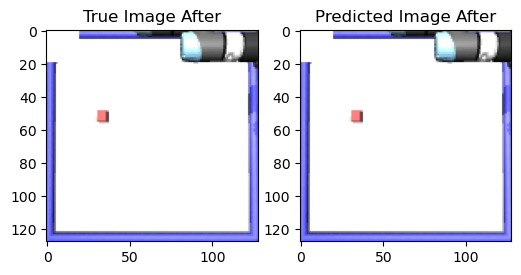

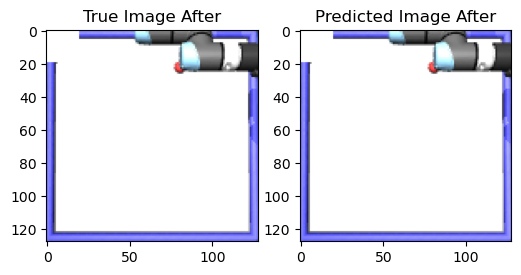

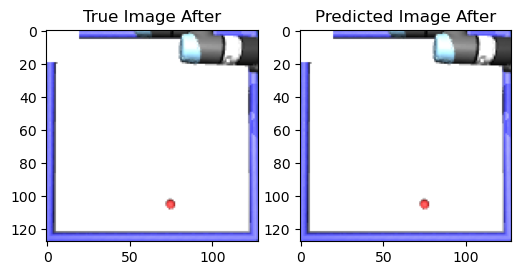

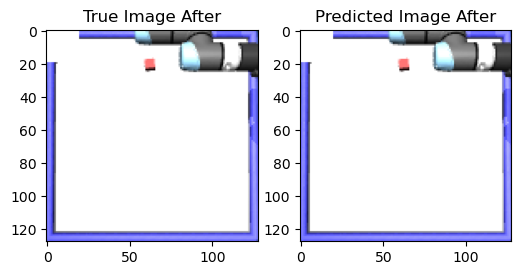

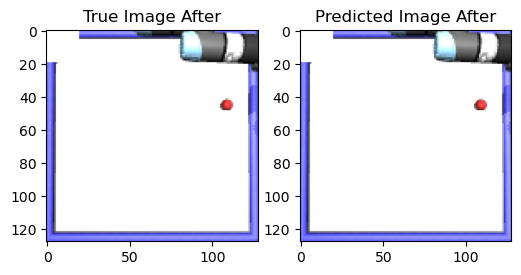

In [ ]:
from homework1 import Hw1Env
import matplotlib.pyplot as plt


def generate_test_data(N=5):
    """Mimics the main function but generates fewer samples for testing."""
    env = Hw1Env(render_mode="offscreen")
    actions = torch.zeros(N, dtype=torch.uint8)
    imgs_before = torch.zeros(N, 3, 128, 128, dtype=torch.uint8)
    imgs_after = torch.zeros(N, 3, 128, 128, dtype=torch.uint8)

    for i in range(N):
        action_id = torch.randint(0, 4, (1,)).item()
        _, img_before = env.state()
        env.step(action_id)
        _, img_after = env.state()

        actions[i] = action_id
        imgs_before[i] = img_before
        imgs_after[i] = img_after
        env.reset()

    return actions, imgs_before, imgs_after


# Generate test data
test_actions, test_imgs_before, test_imgs_after = generate_test_data(N=5)

# Load trained CNN model
cnn_position_predictor = CNNPositionPredictor()
cnn_position_predictor.load_state_dict(torch.load("hw1_3.pt"))
cnn_position_predictor.eval()

for i in range(len(test_actions)):
    action_tensor = F.one_hot(test_actions[i].long(), num_classes=4).float()
    img_before_tensor = test_imgs_before[i].float() / 255.0

    # **Step 1: Predict Final Position (Using CNN)**
    final_pos = cnn_position_predictor(img_before_tensor.unsqueeze(0), action_tensor.unsqueeze(0)).squeeze(0).tolist()

    # **Step 2: Overlay Object on img_after**
    img_after_pred = overlay_object(test_imgs_before[i], test_imgs_after[i], final_pos)

    # **Visualize Results**
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title("True Image After")
    plt.imshow(test_imgs_after[i].permute(1, 2, 0).numpy())
    plt.subplot(1, 2, 2)
    plt.title("Predicted Image After")
    plt.imshow(img_after_pred.permute(1, 2, 0).numpy())
    plt.show()

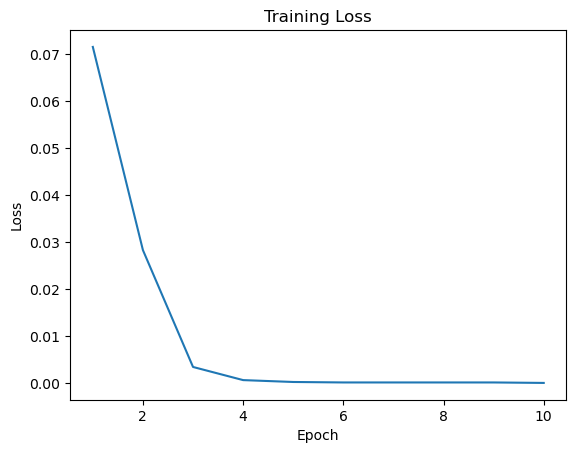

In [ ]:
losses = [0.0716, 0.0283, 0.0034, 0.0006, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001, 0.0000]
plt.plot(range(1, 11), losses)  # Plot losses
plt.xlabel("Epoch")  # Set x-axis label
plt.ylabel("Loss")  # Set y-axis label
plt.title("Training Loss")  # Set title
plt.show()  # Display plot

In [ ]:
def train():
    # Load dataset
    dataset = PositionDataset()
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    cnn_position_predictor = CNNPositionPredictor()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(cnn_position_predictor.parameters(), lr=0.001)

    for epoch in range(10):
        for img_before, action, pos in dataloader:
            optimizer.zero_grad()
            predictions = cnn_position_predictor(img_before, action)
            loss = criterion(predictions, pos)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    # Save trained model
    torch.save(cnn_position_predictor.state_dict(), "hw1_3.pt")
    print("CNN Position Predictor Saved!")

In [ ]:
def test():
    test_actions, test_imgs_before, test_imgs_after = generate_test_data(N=5)

    # Load trained CNN model
    cnn_position_predictor = CNNPositionPredictor()
    cnn_position_predictor.load_state_dict(torch.load("hw1_3.pt"))
    cnn_position_predictor.eval()

    for i in range(len(test_actions)):
        action_tensor = F.one_hot(test_actions[i].long(), num_classes=4).float()
        img_before_tensor = test_imgs_before[i].float() / 255.0

        # **Step 1: Predict Final Position (Using CNN)**
        final_pos = cnn_position_predictor(img_before_tensor.unsqueeze(0), action_tensor.unsqueeze(0)).squeeze(0).tolist()

        # **Step 2: Overlay Object on img_after**
        img_after_pred = overlay_object(test_imgs_before[i], test_imgs_after[i], final_pos)

        # **Visualize Results**
        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.title("True Image After")
        plt.imshow(test_imgs_after[i].permute(1, 2, 0).numpy())
        plt.subplot(1, 2, 2)
        plt.title("Predicted Image After")
        plt.imshow(img_after_pred.permute(1, 2, 0).numpy())
        plt.show()